
# Analysis Tutorial

Welcome to the DNA analysis tutorial using the MDNA module. This notebook will demonstrate different techniques to analyze DNA structures, including simulations, parameter extractions, and visualization of dynamics. You'll learn to:
- Simulate DNA structures using OpenMM.
- Extract and analyze different structural parameters.
- Visualize these parameters to understand DNA behavior.


In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import seaborn as sns


# # # Path: mdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# # import mdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/mdna/')
import mdna as mdna 
%load_ext autoreload
%autoreload 2

/Users/thor/surfdrive/Projects/PMCpy/pmcpy/Evals/PyLk/pylk/writhemap.py:16: UserWarning: Cython version of writhemap (PyLk) not compiled. Defaulting to numba implementation. Consider compiling the cython version.
  warnings.warn(
/Users/thor/surfdrive/Projects/PMCpy/pmcpy/Evals/PyLk/pylk/eval_link.py:10: UserWarning: Cython version of linkingnumber (PyLk) not compiled. Defaulting to numba implementation. Consider compiling the cython version.
  warnings.warn(


### DNA Simulation with OpenMM

Molecular Dynamics (MD) simulations are computational methods used to study the physical movements of atoms and molecules over time. By simulating the interactions and dynamics of molecular structures, MD provides insights into the structural, dynamic, and thermodynamic properties of biological molecules like DNA.

#### About OpenMM
OpenMM is a toolkit for molecular simulations, designed to be extremely flexible and highly efficient. It allows for the rapid development of algorithms and the construction of custom molecular dynamics applications. It is especially optimized for high-performance simulations, making it ideal for studies that require complex, large-scale computations.

#### Simulation Process
1. **Initialization**: We start by creating a DNA simulation from a given sequence. This involves setting up the initial conditions, such as the DNA sequence itself, simulation time, and whether the system should be solvated (surrounded by a solvent, typically water).
   
2. **Centering Coordinates**: To ensure that the DNA structure is properly oriented and centered in the simulation box, we adjust the coordinates. This is crucial for avoiding any boundary issues during the simulation.

3. **Imaging Molecules**: This step involves adjusting the positions of molecules relative to each other based on an anchor molecule. Typically, this helps in maintaining the integrity of the structure throughout the simulation, preventing it from drifting apart across periodic boundaries.

4. **Superposition**: Finally, the trajectory is superposed to a reference frame (usually the first frame) to eliminate any rotational and translational movements that are not intrinsic to the molecule's dynamics.

#### Note
This simulation might take a while to run, depending on the complexity of the DNA sequence and the computational resources available. It's performed to understand the dynamic behavior of the DNA molecule in a simulated physiological environment. Alternatively, you might load your own MD trajectory containing a DNA structure for the purpose of this tutorial.


In [2]:
# Initiate a DNA simulation using OpenMM 
traj = mdna.sequence_to_md(sequence='GCAATATATTGC', time=1, time_unit='nanoseconds', solvated=True, save_location='./data/')
traj.center_coordinates()


Start rescaling spline based on requested number of base pairs.
	This requires recomputation of the control points to match the desired number of base pairs.
	Spline scaled to match the target number of base pairs: 12

Initialize DNA openMM simulation at 310 K for 1 ns time units
Solvate DNA with padding of 1.0 nm and 0.1 M KCl
Minimize energy
Run simulation for 499999 steps
Simulation completed
Saved trajectory as: ./data/my_dna.h5


<mdtraj.Trajectory with 4999 frames, 17187 atoms, 5527 residues, and unitcells at 0x2b1553500>

### Managing DNA Coordinates
Find a residue in the middle, anchor molecules, and adjust the DNA in the simulation box.

In [3]:
# Find index of residue in the middle of the DNA structure
indices = traj.top.select('resid 4')
residx = traj.topology.atom(indices[0]).residue.index
anchor_molecules=[set(traj.topology.residue(residx).atoms)]

# Put everything in the same box based on the anchor residue
traj = traj.image_molecules(anchor_molecules=anchor_molecules)
traj = traj.superpose(traj, 0)

## Loading and Analyzing DNA Structure
Load the trajectory, extract mean reference frames, and view base reference frames.

In [4]:
# Load the trajectory
dna = mdna.load(traj)

# Extract mean reference frames and base reference frames
mean_frames = dna.get_frames()
print(mean_frames.shape)

base_frames = dna.get_base_frames()
for res, ref in base_frames.items():
    print(res, ref.shape)
    break

(12, 4999, 4, 3)
DG1 (4999, 4, 3)


## Extracting and Visualizing Rigid Base Parameters
Show how to extract and parameters

In [5]:
# Extract and visualize parameters
base, names = dna.get_parameters(base=True)
print(base.shape, names)

step, names = dna.get_parameters(step=True)
print(step.shape, names)

params, names = dna.get_parameters()
print(params.shape, names)

(4999, 12, 6) ['shear', 'stretch', 'stagger', 'buckle', 'propeller', 'opening']
(4999, 12, 6) ['shift', 'slide', 'rise', 'tilt', 'roll', 'twist']
(4999, 12, 12) ['shear', 'stretch', 'stagger', 'buckle', 'propeller', 'opening', 'shift', 'slide', 'rise', 'tilt', 'roll', 'twist']


We can also extract just a single parameter

In [6]:
name = 'twist'
para = dna.get_parameter(name)
print(para.shape)

(4999, 12)


Next we plot

/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_40850/4214002102.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(base_pairs, rotation=45)


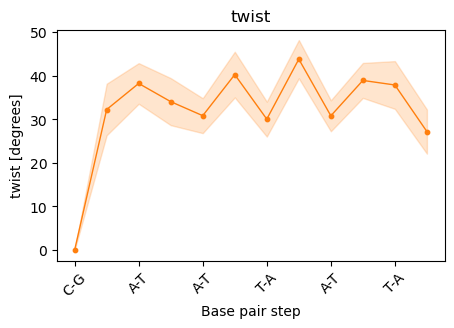

In [7]:

# Plot the twist parameter
fig, ax = plt.subplots(figsize=[5,3])
color = 'tab:orange'
mean = np.mean(para, axis=0)
std = np.std(para, axis=0)
x = range(len(mean))

ax.fill_between(x, mean-std, mean+std, color=color, alpha=0.2)
ax.plot(mean, color=color, lw=1)    
ax.scatter(x=x, y=mean, color=color, s=10)
ax.set_title(name)
ax.set_ylabel(f'{name} [degrees]')
ax.set_xlabel('Base pair step')
base_map = dna.base_pair_map
anti_sequence = [base_map[c] for c in dna.sequence]
base_pairs = [f'{i}-{j}' for i, j in zip(dna.sequence, anti_sequence)]
_ = ax.set_xticklabels(base_pairs, rotation=45)

## Advanced Visualization of DNA Parameters
Use statistical visualization to understand distributions of DNA parameters.

Text(0.75, 0.85, 'Step Parameters')

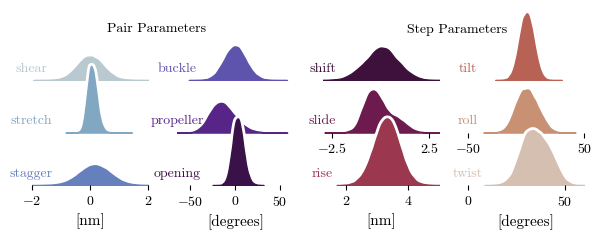

In [8]:
# Example on how to plot KDE's of all parameters
import matplotlib as mpl, matplotlib.font_manager as font_manager
import seaborn as sns
mpl.rcParams['font.family'] = 'serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif'] = cmfont.get_name()
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['axes.formatter.use_mathtext'] = True

colors = sns.color_palette('twilight', 12)
lims = [(-2,2), (-2,2), (-2,2), (-65,65), (-65,65), (-65,65)] + [(-3,3), (-3,3), (1.25,5), (-50,50), (-50,50), (0,60)]
fig, ax = plt.subplots(3, 4, figsize=(6, 2.5), sharey='col')
# ax = ax.flatten()
idx, jdx = 0, 0
for _, name in enumerate(names):
    para = params[:, 1:, names.index(name)]
    sns.kdeplot(para.flatten(), ax=ax[idx][jdx], fill=True, color='white', lw=5)  # density=True
    sns.kdeplot(para.flatten(), ax=ax[idx][jdx], fill=True, color=colors[_], alpha=1, lw=1)  # density=True
    ax[idx][jdx].set_title(name, x=0, y=0, color=colors[_], fontsize=10)
    ax[idx][jdx].set_xlim(lims[_])

    ax[idx][jdx].set_facecolor('none')
    ax[idx][jdx].set_yticklabels([])
    ax[idx][jdx].set_yticks([])
    ax[idx][jdx].set_ylabel('')
    if name in ['shear', 'buckle', 'shift', 'tilt', 'stretch', 'propeller']:
        ax[idx][jdx].set_xticks([])
    idx += 1
    if idx == 3:
        idx = 0
        jdx += 1
    if jdx == 4:
        jdx = 0

    if idx == 0 and jdx in [0, 1, 2, 3]:
        ax[idx][jdx].set_xticklabels([])
    if idx == 1 and jdx in [0, 1]:
        ax[idx][jdx].set_xticklabels([])

ax[-1][0].set_xlabel('[nm]', fontsize=11)
ax[-1][1].set_xlabel('[degrees]', fontsize=11)
ax[-1][2].set_xlabel('[nm]', fontsize=11)
ax[-1][3].set_xlabel('[degrees]', fontsize=11)
fig.tight_layout()
fig.subplots_adjust(hspace=-.25)

sns.despine(bottom=True, left=True)
fig.text(0.25, 0.85, 'Pair Parameters', ha='center', fontsize=10)
fig.text(0.75, 0.85, 'Step Parameters', ha='center', fontsize=10)